In [46]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from astropy.time import Time
from scipy.signal import convolve
%matplotlib inline

In [48]:
#Pulsar header
pulsar_data = open("AST326_ARO_B0329+54.dat", "rb")
header_packed = pulsar_data.read(48)
header_unpacked = struct.unpack('=iiiidiiiId', header_packed)

slice_length = header_unpacked[0]
header_length = header_unpacked[1]
number_samples = header_unpacked[2]
data_type = header_unpacked[3]
cadence_raw = header_unpacked[4]
number_freqs = header_unpacked[5]
number_elems = header_unpacked[6]
spec_sum = header_unpacked[7]
handshake_index = header_unpacked[8]
handshake_utc = header_unpacked[9]

#Pulsar frequencies
header_info = pulsar_data.read(number_freqs*4*2)
freq_list = np.frombuffer(header_info[:number_freqs*4*2], dtype=np.float32)
freq_list = freq_list.reshape(-1,2)
freqs = freq_list.mean(axis=1)

#Import the data by averaging to reduce  TRY TO SWITCH THE NUMBERS
data_list = [] 
for i in np.arange(240): 
    data_chunk = []
    for i in np.arange(545): 
        data_header = np.frombuffer(pulsar_data.read(header_length), dtype=np.float32)
        index, az, alt = struct.unpack('Iff', data_header)
        data = np.frombuffer(pulsar_data.read(slice_length-header_length),dtype=np.float32)  
        data_chunk.append(data)
    data_list.append(np.array(data_chunk))  
data_array=np.zeros((545,1024))
number_to_avg = 240
for i in np.arange(number_to_avg):
    data_array = data_list[i] + data_array
avgs = data_array/number_to_avg

#Define time data
timestep = cadence_raw*spec_sum
t = timestep*np.arange(avgs.shape[0]) 
print(avgs)

[[ 4.84275207  7.31236751  6.91320519 ...  4.52215446  4.51937132
  27.08974058]
 [ 4.87172742  7.34594277  6.97705144 ...  4.53941211  4.55477912
  27.24437563]
 [ 4.87573581  7.31025521  7.00006475 ...  4.56492444  4.52661957
  27.25509613]
 ...
 [ 4.90357235  7.40017943  7.05606854 ...  4.59298344  4.57850117
  27.53745671]
 [ 4.8705802   7.31155915  6.95731273 ...  4.55854505  4.52712955
  27.14648588]
 [ 4.84010117  7.27044546  6.95517266 ...  4.56319576  4.52562664
  27.10638122]]


In [15]:
6.55360000e-04/2.56e-6

256.0

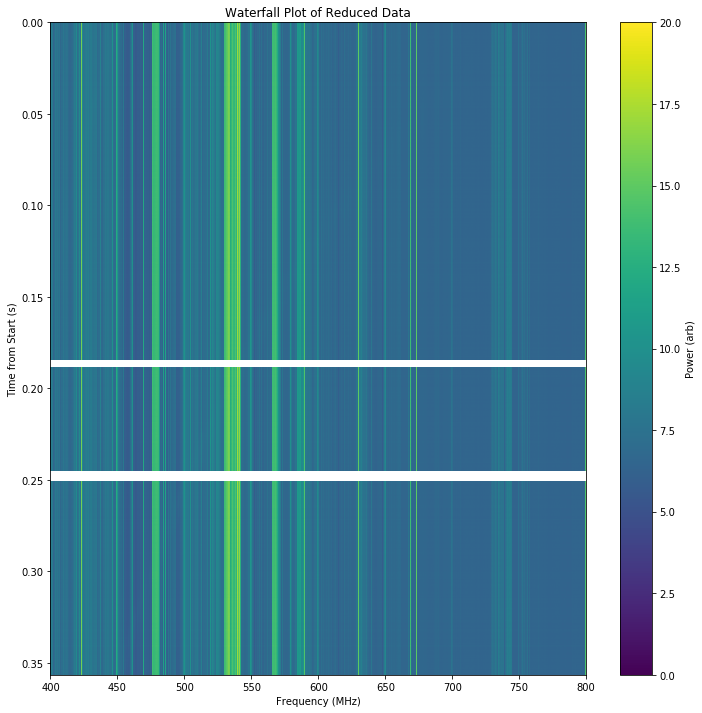

In [41]:
#Waterfall plot of averages
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(avgs),aspect="auto", extent=[400,800,np.amax(t), np.amin(t)], vmax=20, vmin=0)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time from Start (s)')
plt.title('Waterfall Plot of Reduced Data')
plt.colorbar().set_label('Power (arb)', rotation=90)

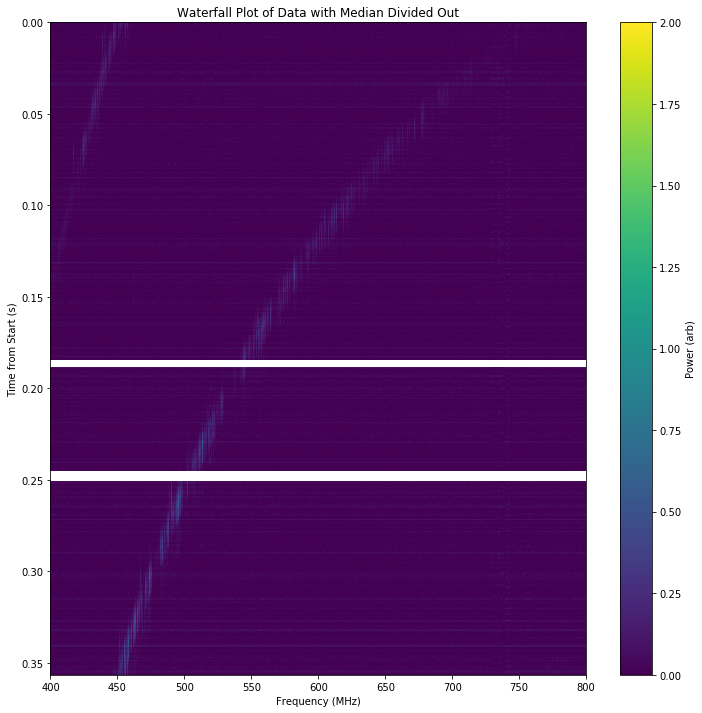

In [42]:
#Divide out RFI
median_RFI = np.median(avgs, axis=0)

RFI_less = avgs/median_RFI
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(RFI_less), extent=[400,800,np.amax(t), np.amin(t)], aspect='auto', vmax=2, vmin=0)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time from Start (s)')
plt.title('Waterfall Plot of Data with Median Divided Out')
plt.colorbar().set_label('Power (arb)', rotation=90)
#plt.savefig('waterfall_clean.pdf')

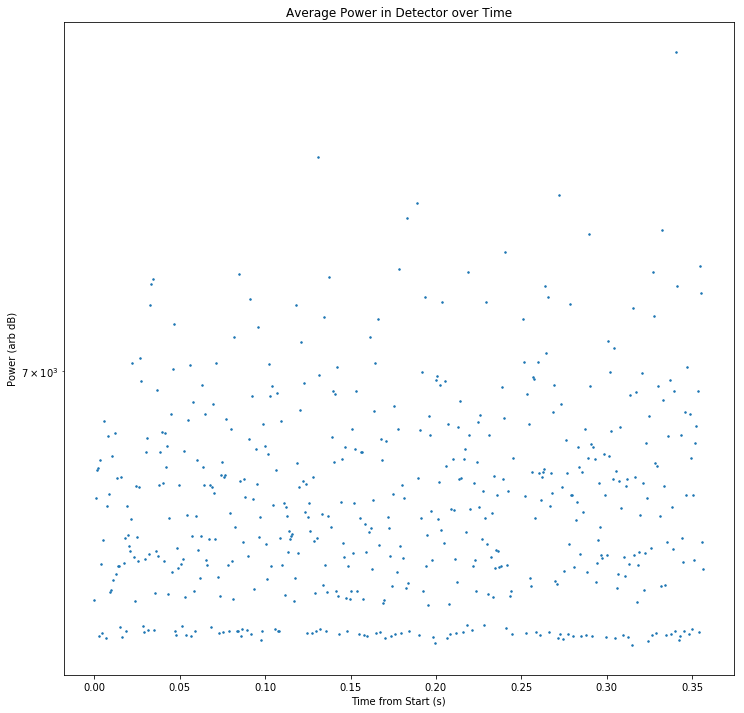

In [43]:
#Get rid of RFI
avgs_sum = np.sum(avgs, axis=1) #Sum over the frequencies
plt.figure(figsize=(12,12))
plt.plot(t, avgs_sum, ls='', marker = 'o', markersize = 1.5)
plt.semilogy()
#plt.ylim(0,7820) #Used this to find where the RFI starts
plt.xlabel('Time from Start (s)')
plt.ylabel('Power (arb dB)')
plt.title('Average Power in Detector over Time')

large_values = np.where(avgs_sum > 7000)
period = 0.714519699726 #period
sample_period = period/timestep #how many samples in a period, dt is time per sample 
number_pulses_exp = int(10000/sample_period) #how many pulses you expect to have (can count these in plot, should be about 9)

In [44]:
#Fold
freq_number = 1024
pixel_bins = 500
folded_pulses = np.zeros((pixel_bins, freq_number))
pulse_in_phase = np.zeros((pixel_bins, freq_number))

RFI_noise = large_values[0].tolist()
RFI_noise.append([0])
for i in np.arange(avgs.shape[0]):
    if i == RFI_noise[0]:
        RFI_noise.pop(0)
        continue
    phase = np.int(pixel_bins*np.modf(i*timestep/period)[0])
    folded_pulses[phase,:] += avgs[i,:] #Summing power
    pulse_in_phase[phase,:] += 1 #How many pulses summing over 

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


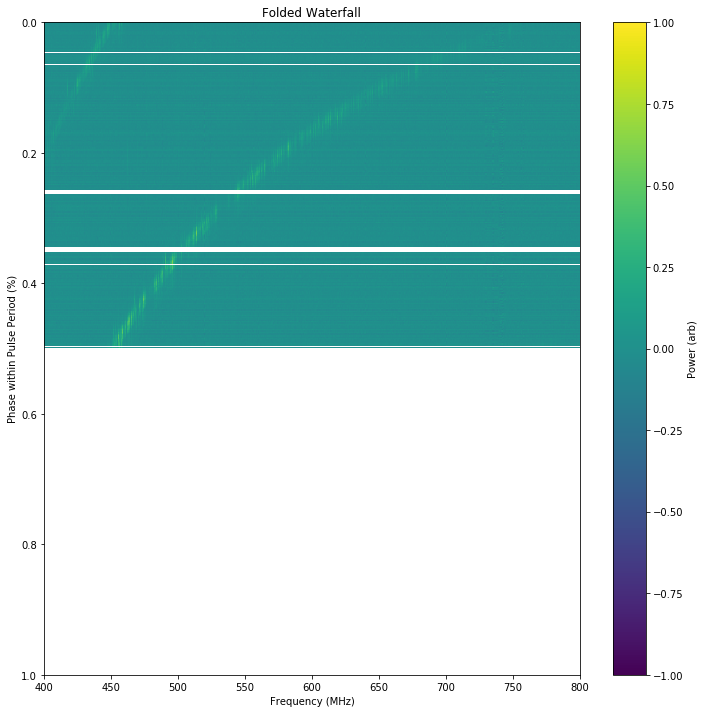

In [45]:
#Check fold
fold_avg = folded_pulses/pulse_in_phase
folded_data = fold_avg/median_RFI

plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(folded_data), extent=[400,800,1, 0], aspect='auto', vmax=1, vmin=-1)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Phase within Pulse Period (%)')
plt.title('Folded Waterfall')
plt.colorbar().set_label('Power (arb)', rotation=90)
#plt.savefig('waterfall_folded.pdf')

Text(0,0.5,'Flux Relative to Background')

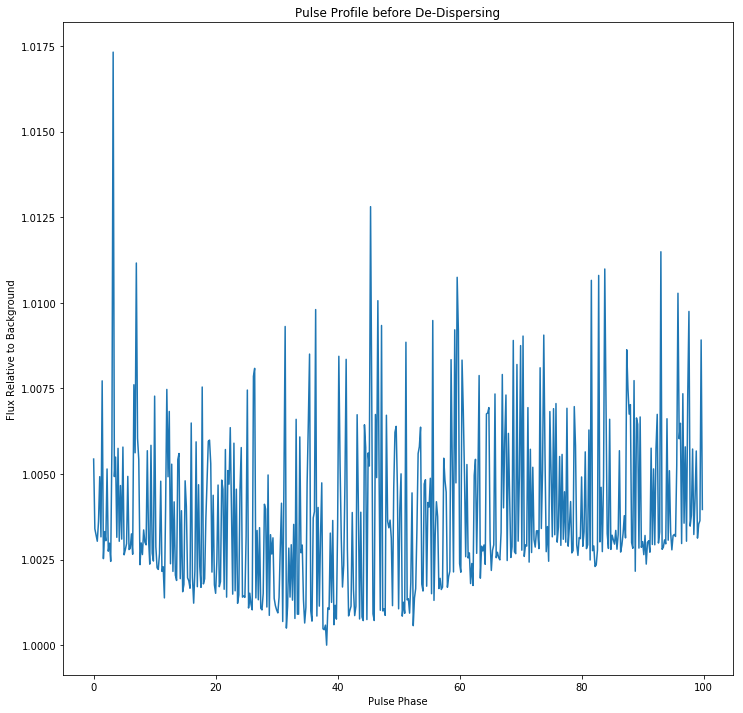

In [36]:
#Plot profile before de-dispersing
profile_dispersed = np.sum(folded_data, axis=1)

#Normalize
normal_profile_dispersed = profile_dispersed/np.min(profile_dispersed)
plt.figure(figsize=(12,12))
plt.plot(np.arange(0,100,100/500),normal_profile_dispersed)
plt.title('Pulse Profile before De-Dispersing')
plt.xlabel('Pulse Phase')
plt.ylabel('Flux Relative to Background')
#plt.savefig('pulse_profile.pdf')

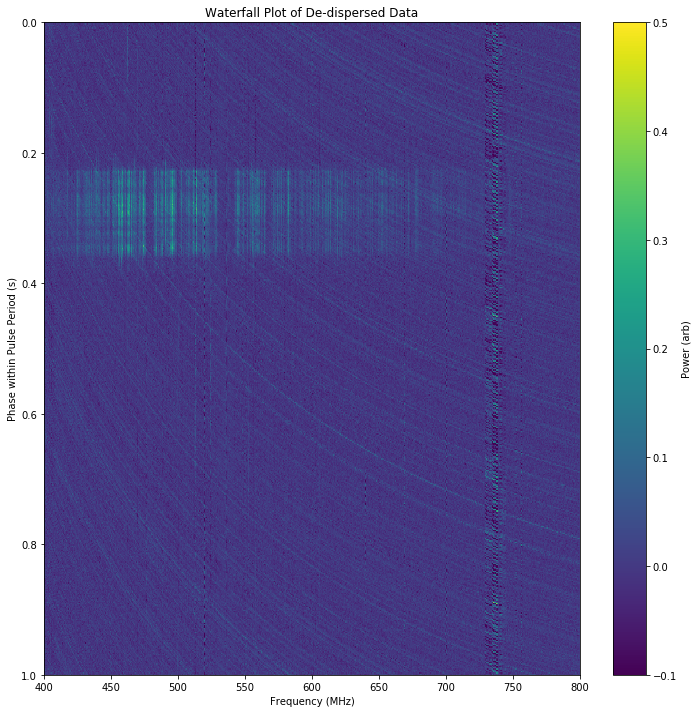

In [37]:
#De-disperse
k = 4.15e-3 #DM time prefactor
dm = 26.7641 #Looked up on ATNF - need to put into SI units? (It looks okay so I guess not?)
dispersion = (k*dm*(freqs/1000)**-2) 
dm_array = np.zeros((500,1024))
for i in np.arange(freq_number):
    dm_array[:,i] = np.roll(folded_data[:,i], -int(dispersion[i]/period*pixel_bins))
    
dedispersed_data = dm_array/np.median(dm_array, axis=0)

plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(dedispersed_data), extent = [np.amin(freqs), np.amax(freqs), 1, 0], aspect = 'auto', vmin = -.1, vmax = .5)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Phase within Pulse Period (s)')
plt.title('Waterfall Plot of De-dispersed Data')
plt.colorbar().set_label('Power (arb)', rotation=90)
#plt.savefig('waterfall_de_dispersed.pdf')

Text(0,0.5,'Flux Relative to Background')

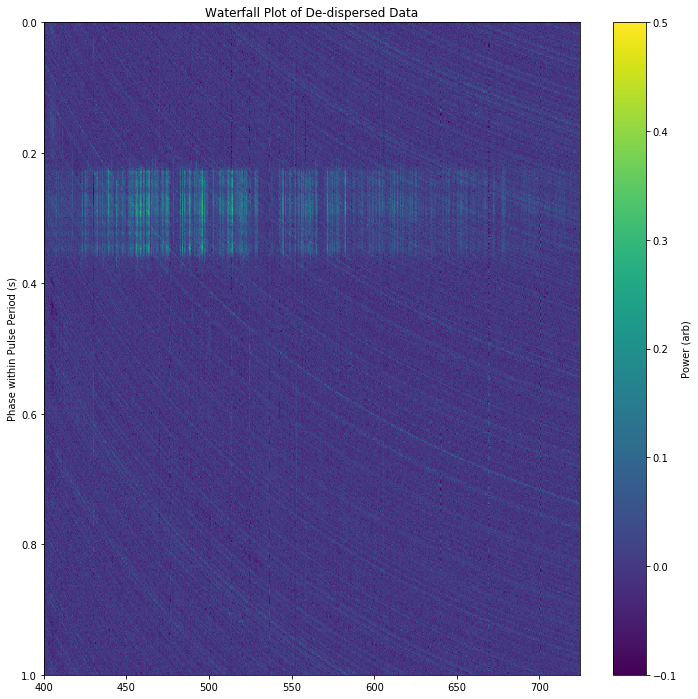

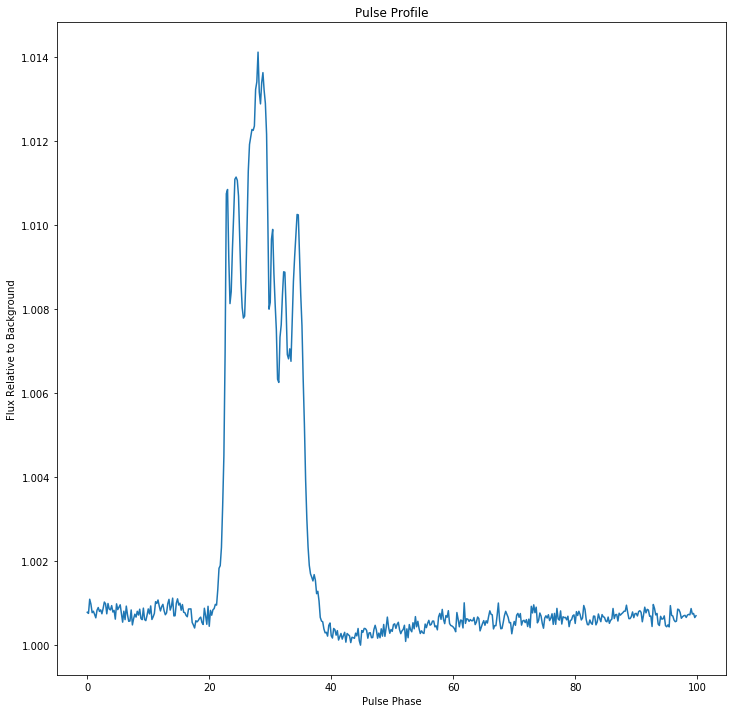

In [38]:
LTE_less = []
temp_list = []
for i in np.arange(0,500):
    temp_list = list(dedispersed_data[i][0:830])
    LTE_less.extend(temp_list)

LTE_less_array = np.array(LTE_less)
LTE_reshaped = LTE_less_array.reshape(500,830)
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(LTE_reshaped), extent = [np.amin(freqs), 724.41406, 1, 0], aspect = 'auto', vmin = -.1, vmax = .5)
plt.title('De-dispersed Data with LTE Band Excised')
plt.ylabel('Phase within Pulse Period (s)')
plt.title('Waterfall Plot of De-dispersed Data')
plt.colorbar().set_label('Power (arb)', rotation=90)
#plt.savefig('waterfall_dedispersed_noLTE.pdf')

profile = np.sum(LTE_reshaped, axis=1)

#Normalize
normal_profile = profile/np.min(profile)
plt.figure(figsize=(12,12))
plt.plot(np.arange(0,100,100/500),normal_profile)
plt.title('Pulse Profile')
plt.xlabel('Pulse Phase')
plt.ylabel('Flux Relative to Background')
#plt.savefig('pulse_profile.pdf')

(array([1.1791e+04, 4.3720e+03, 5.6000e+01, 4.5000e+01, 4.0000e+01,
        3.0000e+01, 2.3000e+01, 1.3000e+01, 1.0000e+01, 4.0000e+00]),
 array([0.86601141, 1.02027773, 1.17454404, 1.32881036, 1.48307668,
        1.637343  , 1.79160932, 1.94587564, 2.10014195, 2.25440827,
        2.40867459]),
 <a list of 10 Patch objects>)

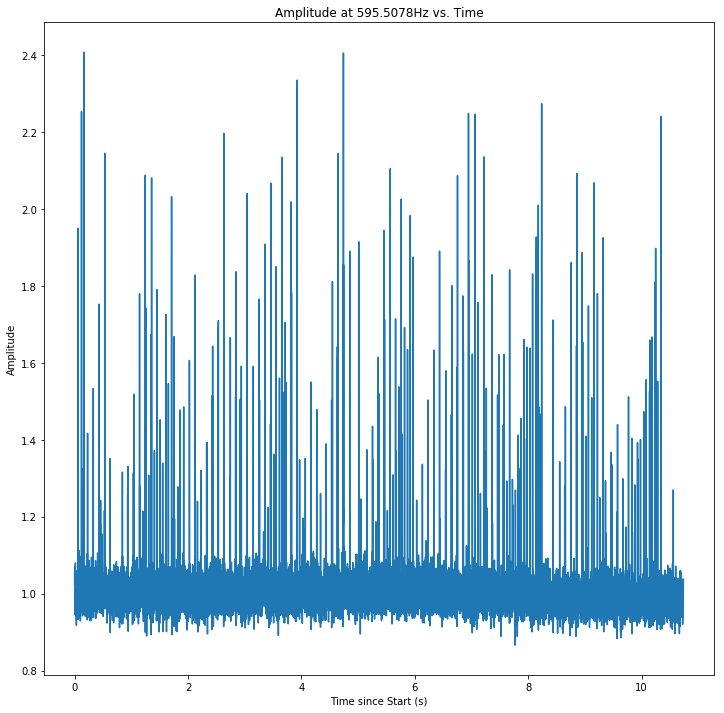

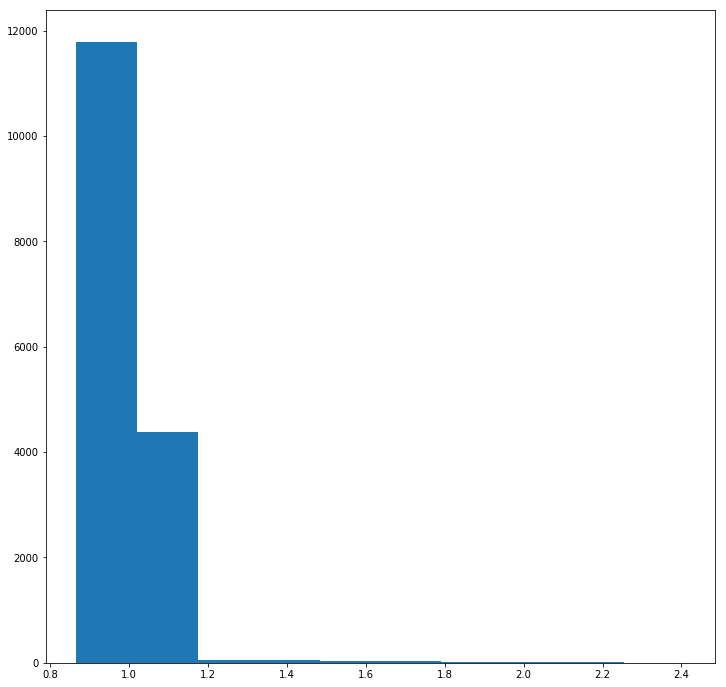

In [11]:
#How pulse amplitudes vary in time
amplitude_1freq = RFI_less[:,500]
#print(freqs[500])
#print(amplitude_1freq.shape)
plt.figure(figsize=(12,12))
plt.plot(t, amplitude_1freq)
plt.title('Amplitude at 595.5078Hz vs. Time')
plt.xlabel('Time since Start (s)')
plt.ylabel('Amplitude')

#Plot histogram
plt.figure(figsize=(12,12))
plt.hist(amplitude_1freq, bins=10)

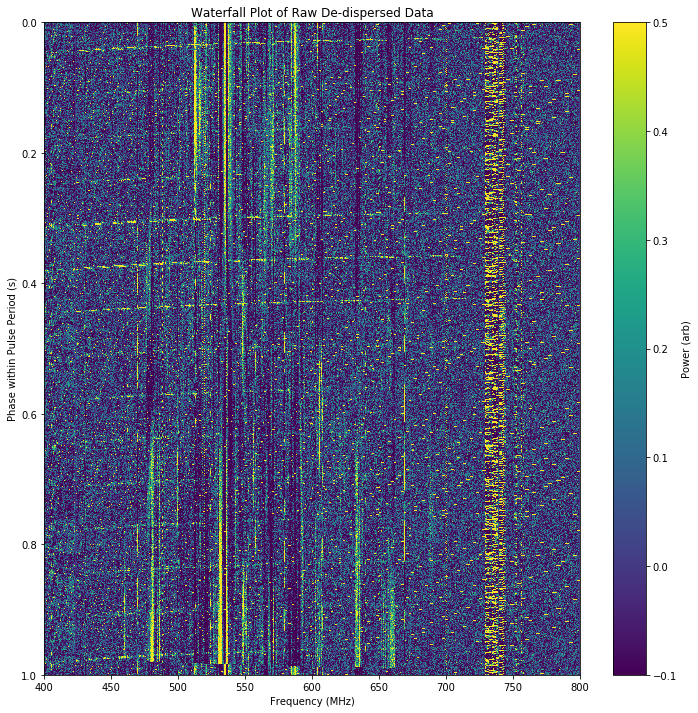

In [12]:
#De-disperse raw dataset 
k = 4.15e-3 #DM time prefactor
dm = 26.7641 #Looked up on ATNF - need to put into SI units? (It looks okay so I guess not?)
dispersion = (k*dm*(freqs/1000)**-2) 
dm_array_raw = np.zeros((16384,1024))
for i in np.arange(freq_number):
    dm_array_raw[:,i] = np.roll(RFI_less[:,i], -int(dispersion[i]/period*pixel_bins))
    
dedispersed_raw = dm_array_raw/np.median(dm_array_raw, axis=0)

plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(dedispersed_raw), extent = [np.amin(freqs), np.amax(freqs), 1, 0], aspect = 'auto', vmin = -.1, vmax = .5)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Phase within Pulse Period (s)')
plt.title('Waterfall Plot of Raw De-dispersed Data')
plt.colorbar().set_label('Power (arb)', rotation=90)

Text(0,0.5,'Power (arb dB)')

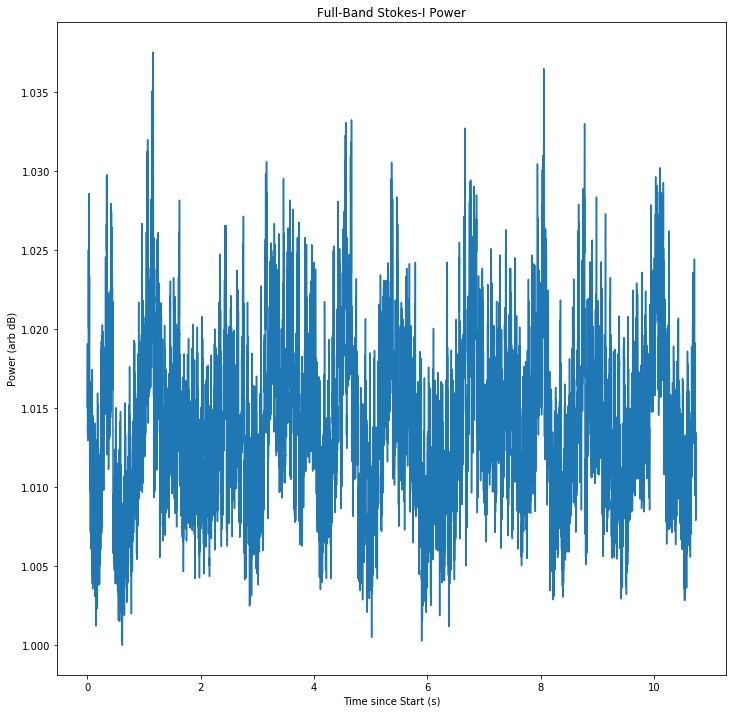

In [13]:
#Sum across frequency
summed_raw_dedispersed = np.sum(dedispersed_raw, axis=1)

#Normalize
normal_raw_profile = summed_raw_dedispersed/np.min(summed_raw_dedispersed)

#Plot as single timestream showing full band Stokes-I power
plt.figure(figsize=(12,12))
plt.plot(t, normal_raw_profile)
plt.title('Full-Band Stokes-I Power')
plt.xlabel('Time since Start (s)')
plt.ylabel('Power (arb dB)')

In [18]:
print(normal_profile.shape)
print(normal_raw_profile.shape)

(500,)
(16000,)


Text(0,0.5,'?')

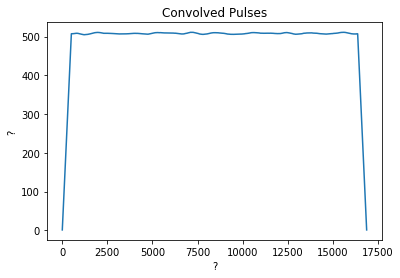

In [14]:
#Maximize sensitivity to each pulse by convolving timestream within it
convolved_pulses = convolve(normal_profile, normal_raw_profile, mode='full', method='auto')
plt.figure()
plt.plot(convolved_pulses)
plt.title('Convolved Pulses')
plt.xlabel('?')
plt.ylabel('?')

In [68]:
2**17/.7

187245.7142857143

In [70]:
18724*.7

131072.19999999998